In [106]:
%matplotlib qt
import matplotlib.pyplot as plt
import os
import numpy as np
import mne
from mne_bids import make_bids_basename, read_raw_bids

mne.set_log_level('WARNING')

from mne.forward import read_forward_solution
from mne.minimum_norm import make_inverse_operator, apply_inverse, write_inverse_operator
from mne.minimum_norm import apply_inverse_raw, apply_inverse_epochs
from mayavi import mlab
from IPython.display import Image

from nilearn.plotting import plot_stat_map
from nilearn.image import index_img

In [15]:
sSub, session, task, run = '08', '01', 'picturenaming', '01'
bids_basename = make_bids_basename(subject=sSub, session=session, task=task, run=run)
data_dir = '/Users/chholak/data/pic-name-data-bids/'
res_dir = '/Users/chholak/research/results/pic_name/'
data_path = data_dir + 'MEG/'
bids_path = data_path + 'sub-' + sSub + '/ses-' + session + '/meg/'

subjects_dir = os.path.join(data_dir, 'MRI/')
subject = 'sub-' + sSub

raw_fname = bids_path + bids_basename + '_meg.fif'
epochs_fname = raw_fname.replace('_meg.fif', '-epo.fif')

In [3]:
epochs = mne.read_epochs(epochs_fname)
epochs

<EpochsFIF  |   98 events (all good), -0.5 - 1 sec, baseline [-0.5, 0], ~351.3 MB, data loaded,
 'picture': 98>

In [4]:
epochs.pick_types(meg=True, eeg=False)

<EpochsFIF  |   98 events (all good), -0.5 - 1 sec, baseline [-0.5, 0], ~349.0 MB, data loaded,
 'picture': 98>

In [5]:
evoked = epochs.average()

In [9]:
evoked.plot_topomap(times=np.linspace(0.1, 0.3, 5), ch_type='mag');
plt.savefig(res_dir + 'evoked_topomap_mag_' + 'sub-' + sSub + '.pdf')

In [10]:
noise_cov = mne.compute_covariance(epochs, tmax=0, method=['shrunk', 'empirical'],
                                  rank='info')
print(noise_cov.data.shape)

(306, 306)


In [11]:
mne.viz.plot_cov(noise_cov, epochs.info)

(<Figure size 760x370 with 4 Axes>, <Figure size 760x370 with 2 Axes>)

In [13]:
evoked.plot_white(noise_cov);
plt.savefig(res_dir + 'evoked_plot_white_' + 'sub-' + sSub + '.pdf')

In [16]:
fwd_fname = os.path.join(bids_path, subject + '-meg-fwd.fif')
fwd = read_forward_solution(fwd_fname)
fwd = mne.convert_forward_solution(fwd, surf_ori=True)
fwd = mne.pick_types_forward(fwd, meg=True, eeg=False)
info = evoked.info
inverse_operator = make_inverse_operator(info, fwd, noise_cov,
                                        loose=0.2, depth=0.8)

In [17]:
method = "dSPM"
snr = 3.
lambda2 = 1. / snr ** 2
stc = apply_inverse(evoked, inverse_operator, lambda2,
                   method=method, pick_ori=None)
print(stc)

<SourceEstimate  |  8196 vertices, subject : sub-08, tmin : -500.0 (ms), tmax : 1000.0 (ms), tstep : 1.0 (ms), data shape : (8196, 1501)>


In [33]:
stc_fname = res_dir + 'dspm_' + 'sub-' + sSub
stc.save(stc_fname)

In [86]:
snr, _ = mne.minimum_norm.estimate_snr(evoked, inverse_operator, verbose=True)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 98
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 2)
    Created the whitener using a noise covariance matrix with rank 69 (237 small eigenvalues omitted)
Picked 306 channels from the data
Effective nchan = 306 - 237 = 69


In [108]:
plt.plot(evoked.times, snr)
plt.show()
plt.savefig(res_dir + 'SNR_dSPM_' + 'sub-' + sSub + '.pdf')

In [109]:
test_time = 0.212
tstep = 1000 / (evoked.info['sfreq'] * 1000)
tp = int(test_time // tstep - evoked.times[0] // tstep)
print("SNR:", snr[tp])

SNR: 3.2394875760828628


In [27]:
brain = stc.plot(surface='inflated', hemi='both', subjects_dir=subjects_dir,
                time_viewer=False)
brain.set_data_time_index(700)
brain.scale_data_colormap(fmin=3, fmid=5, fmax=7, transparent=True)
brain.show_view('parietal')

colormap sequential: [3.00e+00, 5.00e+00, 7.00e+00] (transparent)


((-59.99999999999999,
  59.99999999999999,
  432.1112365722657,
  array([-0.59938049,  0.        ,  0.        ])),
 -49.105999999999995)

In [28]:
dspm_fname = res_dir + 'dspm_' + 'sub-' + sSub + '.png'
brain.save_image(dspm_fname)
mlab.close()

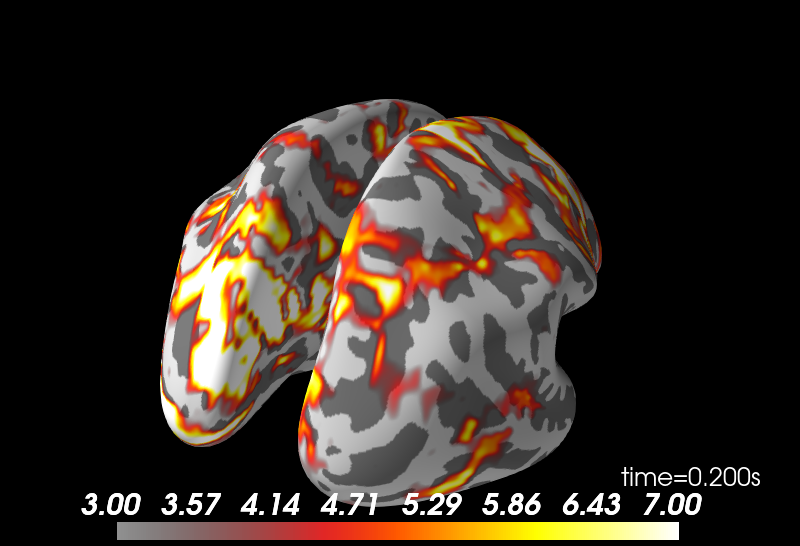

In [29]:
Image(filename=dspm_fname, width=600)

In [ ]:
# mne.datasets.fetch_fsaverage(subjects_dir=subjects_dir)

# morph = mne.compute_source_morph(stc, subject_from=subject,
#                                 subject_to='fsaverage', subjects_dir=subjects_dir)
# stc_fsaverage = morph.apply(stc)

# stc_fsavg_fname = res_dir + 'fsaverage_dspm_' + 'sub-' + sSub
# stc_fsaverage.save(stc_fsavg_fname)

# brain_fsaverage = stc_fsaverage.plot(surface='inflated', hemi='both',
#                                     subjects_dir=subjects_dir)
# brain_fsaverage.set_data_time_index(700)
# brain_fsaverage.scale_data_colormap(fmin=3, fmid=5, fmax=7, transparent=True)
# brain_fsaverage.show_view('parietal')

# brain_fsaverage.save_image('dspm_fsaverage.jpg')
# mlab.close()

# Image(filename='dspm_fsaverage.jpg', width=600)

In [35]:
labels = mne.read_labels_from_annot(subject, 'HCPMMP1', 'both', subjects_dir=subjects_dir)

In [36]:
labels_vis = []
# ROI = ['L_V1_ROI-lh', 'R_V1_ROI-rh', 'L_V2_ROI-lh', 'R_V2_ROI-rh']
ROI = ['L_V1_ROI-lh', 'R_V1_ROI-rh']
for lbl in labels:
    if lbl.name in ROI:
        labels_vis.append(lbl)
label = labels_vis[0]
for i in range(1, len(labels_vis)):
    label = label + labels_vis[i]
label

<BiHemiLabel  |  sub-08, 'L_V1_ROI-lh + R_V1_ROI-rh', lh : 4181 vertices,  rh : 4178 vertices>

In [46]:
stc_evoked = apply_inverse(evoked, inverse_operator, lambda2, method, pick_ori="normal")
stc_evoked_label = stc_evoked.in_label(label)

flip = mne.label_sign_flip(label, inverse_operator['src'])
label_mean_evoked = np.mean(stc_evoked_label.data, axis=0)
label_mean_evoked_flip = np.mean(flip[:, np.newaxis] * stc_evoked_label.data, axis=0)

In [49]:
times = 1e3 * stcs[0].times # times in ms

plt.figure()
h0 = plt.plot(times, stc_evoked_label.data.T, 'k')
h1, = plt.plot(times, label_mean_evoked, 'r', linewidth=3)
h3, = plt.plot(times, label_mean_evoked_flip, 'g', linewidth=3)
plt.legend((h0[0], h1, h2), ('all dipoles in label', 'mean', 'mean with flip'))
plt.xlabel('time (ms)')
plt.ylabel('dSPM value')
plt.show()
plt.savefig(res_dir + 'evoked_label_' + 'sub-' + sSub + '.pdf')

/Users/chholak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  # This is added back by InteractiveShellApp.init_path()
/Users/chholak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  # This is added back by InteractiveShellApp.init_path()
/Users/chholak/anaconda3/lib/python3.7/site-packages/ipykernel/eventloops.py:106: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  app.exec_()


In [60]:
src_peak, t_peak = stc.get_peak()
t_peak

0.21199999999999997